### Import Libraries 

In [20]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline 
import xgboost as xgb

#Need to clean further 

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler,OneHotEncoder, OrdinalEncoder

from sklearn.metrics import confusion_matrix,accuracy_score, classification_report  # Import accuracy_score


from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,StandardScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn import metrics


from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, f1_score, precision_score, recall_score, make_scorer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning

# Filter out UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

#Import Custom Functions 
from Standardization import metric_normalizer
from metrics_functions import custom_classification_metrics as CCM, threshold_viz as TV

### Import Dataset

In [2]:
df = pd.read_csv('/home/clivence/Development/Datadump/Datadump/Model_Data/GU_Model_Data_V1_16k')

### Data Cleaning

In [3]:
#Filter out negative values - evetually need to research why this is happening 
df  = df[(df['2D Low in Pips'] > 0) | (df['2D Low in Pips'] > 0)] 

df = df[df['Action'] == 'Ultimate Action']
df = df[df['Ticker'] == 'GBP/USD']

df.fillna(0, inplace=True)

#Standardize the dataset
df =  metric_normalizer(df)

#Set date to datetime 
df['Date'] = pd.to_datetime(df['Date'])

#Create Date Derived Features 
df['Trade_Week_Year'] = df['Date'].dt.isocalendar().week
df['Trade_Week_Month'] = (df['Date'].dt.day -1)//7+1
df['Trade_Day_Week'] = df['Date'].dt.weekday + 1

#Create a new feature to identify the status of the previous trade 
df['Previous_Trade_Status'] = df['2D Trade Status'].shift(fill_value=0)


### Data Preprocessing 

In [4]:
#Subset Selection
df = df[['open', 'high', 'low', 'close', 'volume','Trade_Week_Year','Trade_Week_Month','Trade_Day_Week',
       'Day','Month','25EMA', '50EMA', '75EMA','100EMA', '125EMA',
        'Trend Status', 'Spread','5075 Trend Status', '75100 Trend Status',
       '100125 Trend Status', 'Order Type', 
        '%K', '%D', 'k_group', 'ADX', 'ADXR', 'slowk','slowd','CDL2CROWS', 'CDL3BLACKCROWS',
        'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE',
        'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK',
        'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL',
        'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI',
        'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE',
        'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS',
        'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS',
        'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM',
        'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD',
        'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN',
        'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE',
        'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP',
        'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER', 'CDLUPSIDEGAP2CROWS', 'CDLXSIDEGAP3METHODS',
        'candle_bullish_score','candle_bearish_score','Previous_Trade_Status','2D Trade Status']]

#Set a random state 
state =42

In [5]:
# Set training, test, and validation set size 
total_len = len(df)
training_size = int(total_len * .8)
validation_size = int(total_len * .1)
test_size = total_len - training_size - validation_size

# Split indices
training_idx = df.index[:training_size]
validation_idx = df.index[training_size:training_size + validation_size]
test_idx = df.index[training_size + validation_size:]

# Verify lengths
assert len(training_idx) == training_size
assert len(test_idx) == test_size
assert len(validation_idx) == validation_size

# Create training, test, and validation df 
training_df = df.loc[training_idx]
validation_df = df.loc[validation_idx]
test_df = df.loc[test_idx]

# Print lengths of the three DataFrames
print(f"Training: {len(training_df)}")
print(f"Validation: {len(validation_df)}")
print(f"Test: {len(test_df)}")

Training: 386
Validation: 48
Test: 49


In [6]:
X_train = training_df.drop(columns=['2D Trade Status'])
y_train = training_df['2D Trade Status']
X_val = validation_df.drop(columns=['2D Trade Status'])
y_val = validation_df['2D Trade Status']
X_test = test_df.drop(columns=['2D Trade Status'])
y_test = test_df['2D Trade Status']

In [7]:
#Create a list of columns to encode 
cat_cols_to_encode = ['Order Type']
#Create a list of cols for ordinal encoding 
cat_cols_for_ordinal_encoding = ['Trend Status','5075 Trend Status', '75100 Trend Status',
                    '100125 Trend Status','k_group']

#Create a list of cols to scale 
num_cols_to_scale = ['volume']

# Create Column Transformer with appropriate preprocessing for numerical and categorical data
Preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
            ('scaler', MinMaxScaler())]), num_cols_to_scale),
        ('cat_onehot', OneHotEncoder(drop='first', sparse_output=False), cat_cols_to_encode),
        ('cat_ordinal', OrdinalEncoder(), cat_cols_for_ordinal_encoding)
    ],
    remainder='passthrough')

# Preprocessor.set_output(transform='pandas')

## Base Models

### Logistic Regression

/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Test Accuracy: 0.6458333333333334

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.00      0.00      0.00        13
  Win Trades       0.70      0.89      0.78        35

    accuracy                           0.65        48
   macro avg       0.35      0.44      0.39        48
weighted avg       0.51      0.65      0.57        48



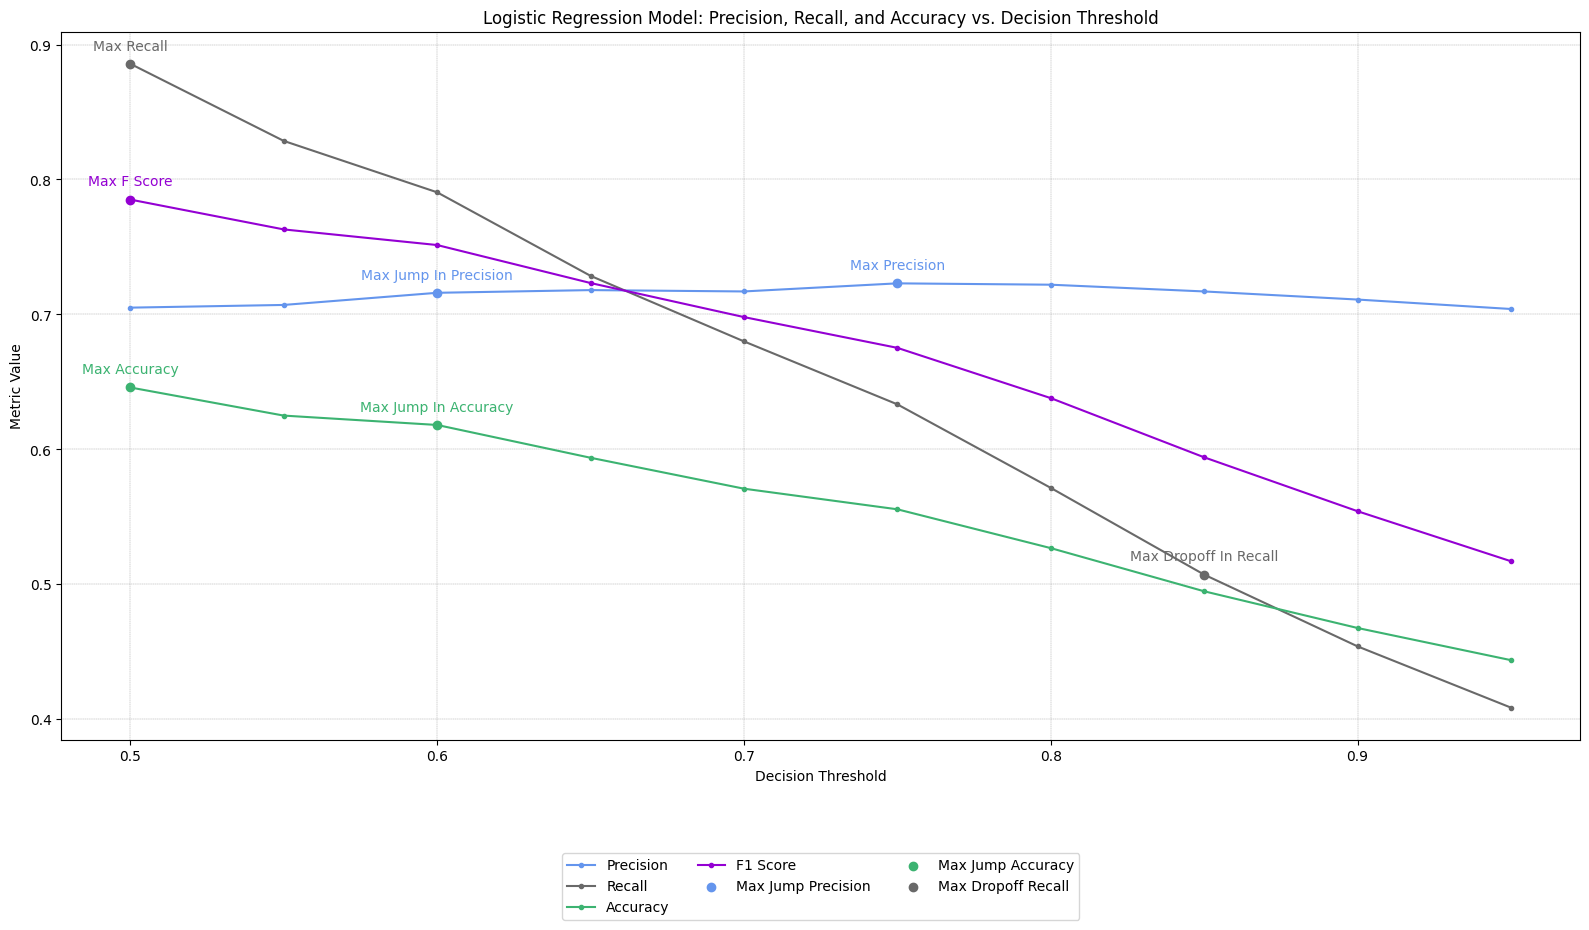

In [10]:
#Create PiPeline to be used in Model
Base_LR_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('LR_Model',LogisticRegression(solver='saga', max_iter=200))])

# Perform cross-validation
Base_LR_Model_Pipeline.fit(X_train, y_train)
Base_LR_Model_Predictions = Base_LR_Model_Pipeline.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, Base_LR_Model_Predictions)
print(f"\nTest Accuracy: {accuracy}\n")

# Generate and Print  classification report
report = classification_report(y_val, Base_LR_Model_Predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)

#Get Predictions Probability 
predictions_array = Base_LR_Model_Pipeline.predict_proba(X_val)[:, 1]

#Get y_values
true_arrray= y_val

#Create custom classification metrics 
metrics= CCM(true_arrray, predictions_array)

##Visualized  Metrics 
model_name= 'Logistic Regression Model'
viz = TV(metrics,model_name)

In [9]:
np.array(y_val).reshape(-1)

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1])

In [10]:
test_preds = Base_LR_Model_Pipeline.predict(X_val)
test_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [11]:

val_preds = Base_LR_Model_Pipeline.predict_proba(X_val)[:,1]
val_preds

array([0.81903921, 0.9093728 , 0.6246222 , 0.57408581, 0.58979566,
       0.54442157, 0.75727757, 0.53710291, 0.77782643, 0.66333329,
       0.63640752, 0.73910224, 0.64342953, 0.75751573, 0.70080807,
       0.83931373, 0.61020679, 0.57087916, 0.18011279, 0.49093272,
       0.51208909, 0.64972082, 0.71617851, 0.79522478, 0.53460522,
       0.6019469 , 0.80959969, 0.82688179, 0.21278618, 0.72375154,
       0.50644682, 0.49781543, 0.70501077, 0.8471806 , 0.96619504,
       0.88357635, 0.82780877, 0.76473249, 0.77412813, 0.73773392,
       0.64027334, 0.59775935, 0.60887361, 0.75902035, 0.52975901,
       0.96396373, 0.69464134, 0.75972643])

In [12]:
# val_preds = Base_LR_Model_Pipeline.predict_proba(X_val)[:,1]

# TP = 0
# FP = 0
# threshold = .5
# for i in range(0,len(y_val)):
#     a = val_preds[i]
#     b = y_val.iloc[i]
#     if a > threshold:
#         if b == 1:
#             TP += 1
#         else:
#             FP += 1
# boosted_precision_baseline = round(TP/(TP+FP),3)
# boosted_precision_baseline

0.705

In [13]:
val_preds = Base_LR_Model_Pipeline.predict_proba(X_val)[:, 1]

TP = 0
FP = 0
TN = 0
FN = 0
thresholds = [i / 100 for i in range(50, 100, 5)]
precision_list = []
recall_list =[]
accuracy_list = []
for threshold in thresholds:
    # threshold = b
    for i in range(len(y_val)):
        a = val_preds[i]
        b = y_val.iloc[i]
        if a > threshold:
            if b == 1:
                TP += 1
            else:
                FP += 1
        else:
            if b == 1:
                FN += 1
            else:
                TN += 1
    
    if TP + FP > 0:
        precision = round(TP / (TP + FP),3)
        precision_list.append(precision)
    else:
        precision = 0
        precision_list.append(precision)
    
    if TP + FN > 0:
        recall = round(TP / (TP + FN),3)
        recall_list.append(recall)
    else:
        recall = 0
        recall_list.append(recall)
    
    accuracy = round((TP + TN) / (TP + TN + FP + FN),3)
    accuracy_list.append(accuracy)


In [18]:

# np.array(y_train).reshape(-1)

# test_preds = grid_search.predict(x_test)

# precision_baseline = int(round(metrics.precision_score(y_test, test_preds))*100,0)
# recall_baseline = int(round(metrics.recall_score(y_test, test_preds))*100,0)
# f1_baseline = int(round(metrics.f1_score(y_test, test_preds))*100,0)
# roc_baseline = int(round(metrics.roc_auc_score(y_test, test_preds))*100,0)

# grid_search.predict(x_test)

# grid_search.predict_proba(x_test)[:,1]

# test_probs = grid_search.predict_proba(x_test)

# TP = 0
# FP = 0
# threshold = .55
# for i in range(0,len(y_test)):
# a = test_probs[i,1]
# b = y_test.iloc[1][0]
# if a > threshold:
# if b == '1':
# TP += 1
# else:
# FP += 1
# boosted_precision_baseline = int(round((TP/(TP+FP))))

# def boosted_precision(y_true, y_pred_proba):
# y_pred_binary = (y_pred_proba >= .85).astype(int)
# precision = precision_score(y_true, y_pred_binary)
# return precision

# boosted_precision_scorer = make_scorer(boosted_precision, response_method='predict', greater_is_better=True)

# grid_search_P = GridSearchCV(rf_pipe,paramas = paramgrid, cv=3,scoring='average_precision')
# grid_search_P.fit(x_train, y_train)



### Decision Tree Classifier 


Test Accuracy: 0.6041666666666666

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.25      0.23      0.24        13
  Win Trades       0.72      0.74      0.73        35

    accuracy                           0.60        48
   macro avg       0.49      0.49      0.49        48
weighted avg       0.59      0.60      0.60        48



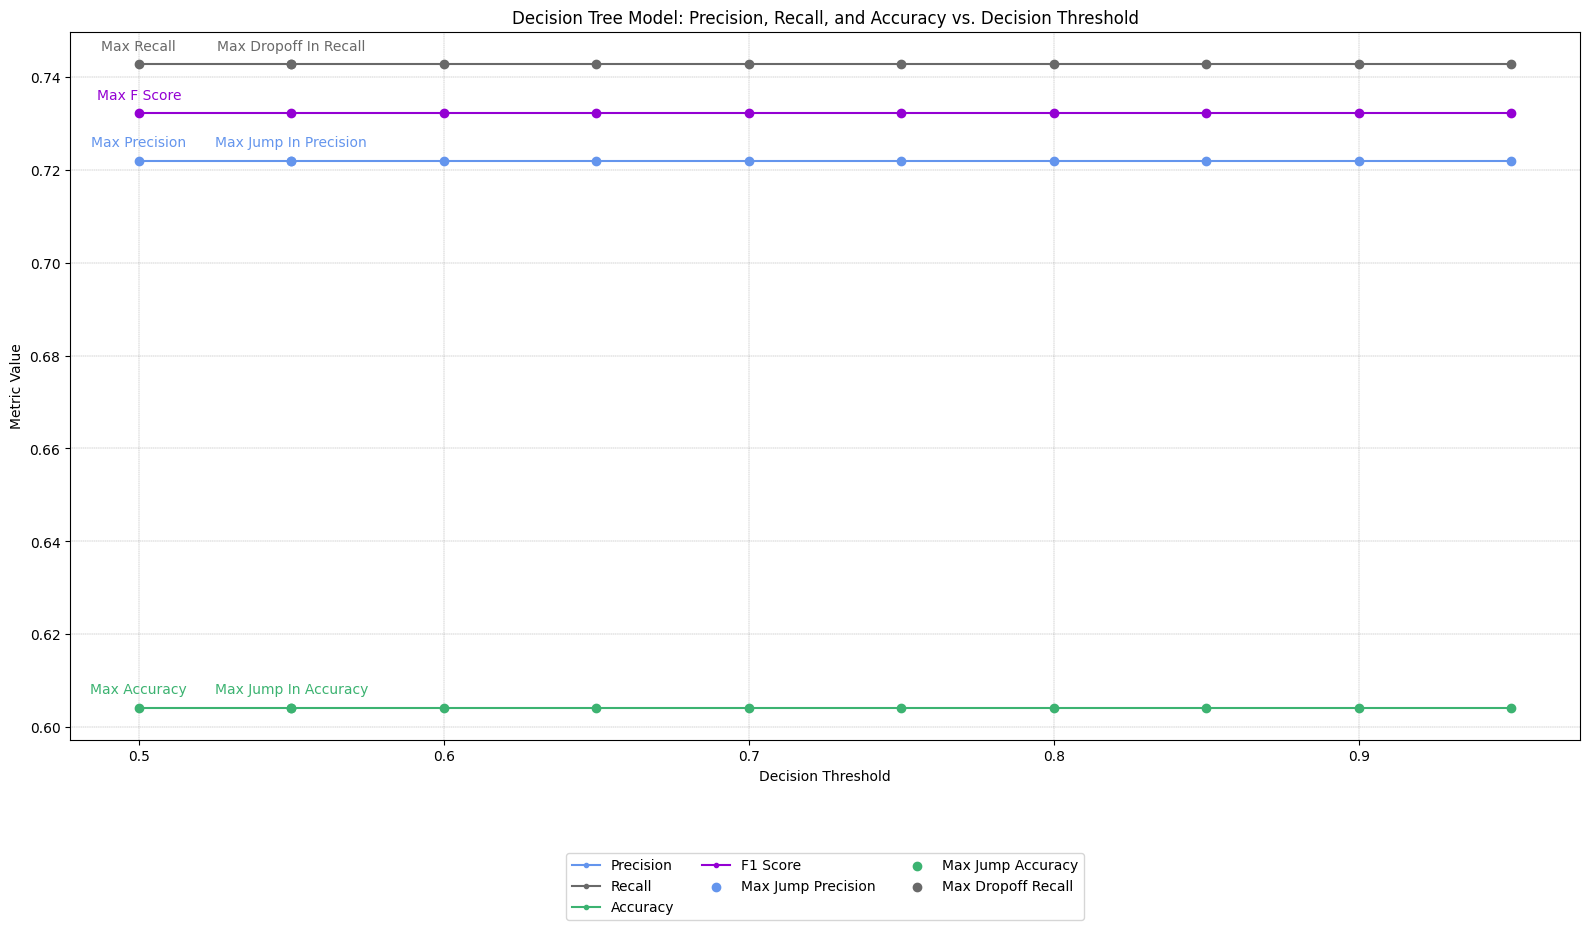

In [12]:
#Create Pipeline to be used in Descision Tree Model
Base_DT_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('DT_Model',DecisionTreeClassifier(random_state=state))])

#Fit the training data 
Base_DT_Model_Pipeline.fit(X_train, y_train)

#Make Predictions on the test set 
Base_DT_Model_Predictions = Base_DT_Model_Pipeline.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, Base_DT_Model_Predictions)
print(f"\nTest Accuracy: {accuracy}\n")

# Generate  and Print a classification report
report = classification_report(y_val, Base_DT_Model_Predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)

#Get Predictions Probability 
predictions_array = Base_DT_Model_Pipeline.predict_proba(X_val)[:, 1]

#Get y_values
true_arrray= y_val

#Create custom classification metrics 
metrics= CCM(true_arrray, predictions_array)

##Visualized  Metrics 
model_name= 'Decision Tree Model'
viz = TV(metrics,model_name)

### Random Forest Classifier


Test Accuracy: 0.7291666666666666

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.00      0.00      0.00        13
  Win Trades       0.73      1.00      0.84        35

    accuracy                           0.73        48
   macro avg       0.36      0.50      0.42        48
weighted avg       0.53      0.73      0.61        48



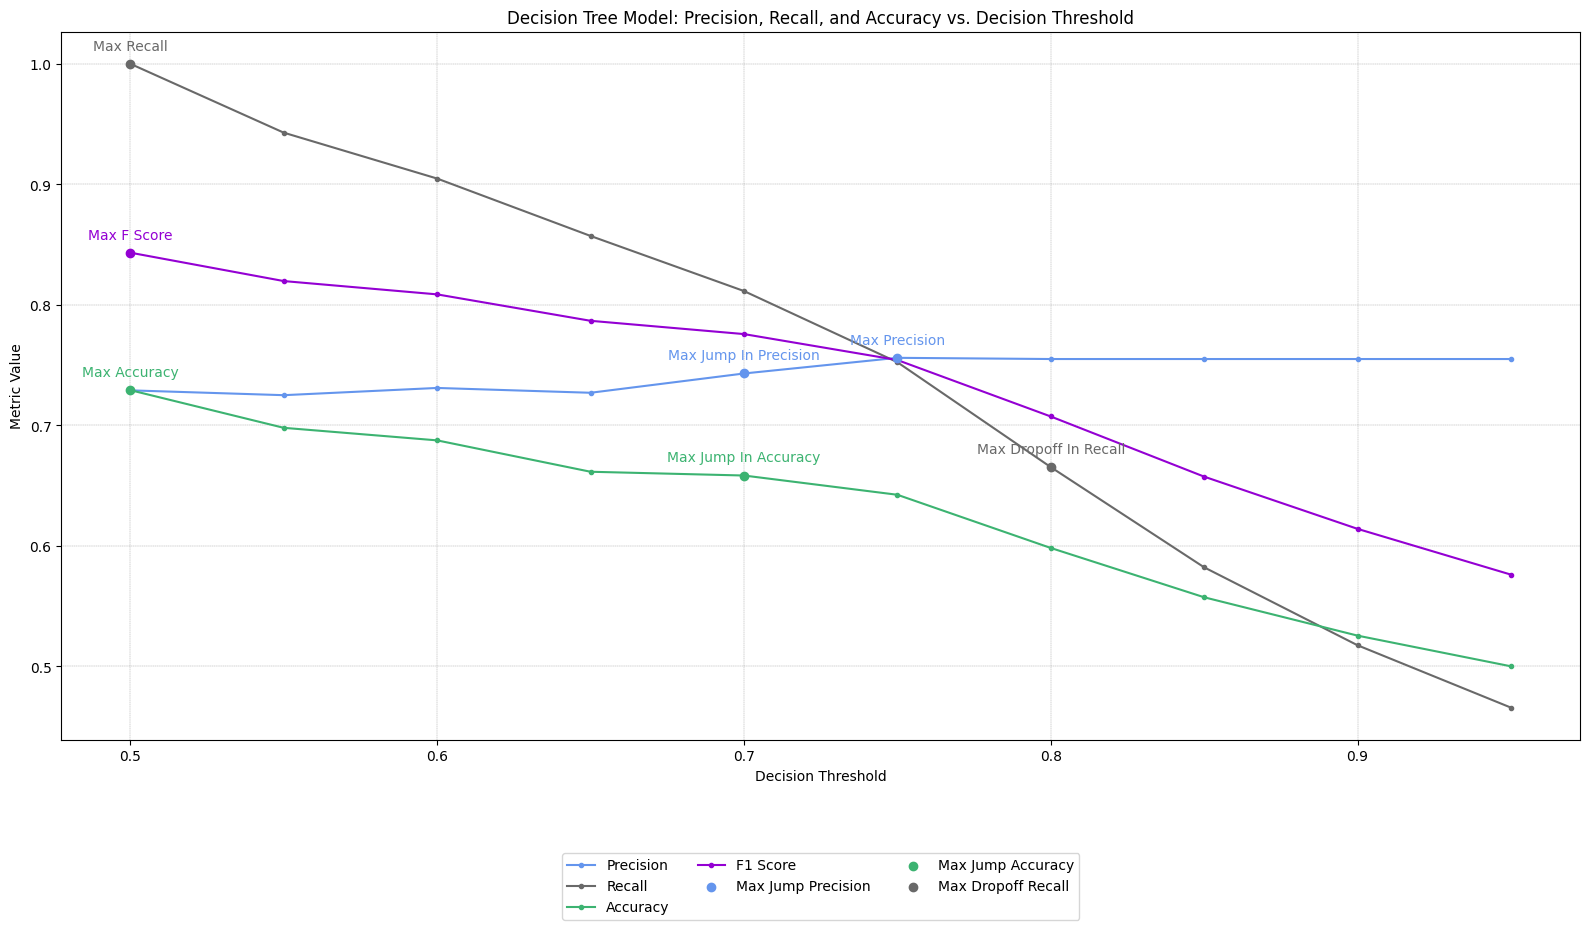

In [13]:
# Create Model Pipeline
Base_RF_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('RF_Model', RandomForestClassifier(random_state=state))  
])

#Fit the training data 
Base_RF_Model_Pipeline.fit(X_train, y_train)

# Make Predictions
RF_CV_predictions = Base_RF_Model_Pipeline.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, RF_CV_predictions)
print(f"\nTest Accuracy: {accuracy}\n")

# Generate  and Print a classification report
report = classification_report(y_val, RF_CV_predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)

#Get Predictions Probability 
predictions_array = Base_RF_Model_Pipeline.predict_proba(X_val)[:, 1]

#Get y_values
true_arrray= y_val

#Create custom classification metrics 
metrics= CCM(true_arrray, predictions_array)

##Visualized  Metrics 
model_name= 'Decision Tree Model'
viz = TV(metrics,model_name)

### Gradient Boosting Classifier


Test Accuracy: 0.7291666666666666

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.50      0.08      0.13        13
  Win Trades       0.74      0.97      0.84        35

    accuracy                           0.73        48
   macro avg       0.62      0.52      0.49        48
weighted avg       0.67      0.73      0.65        48



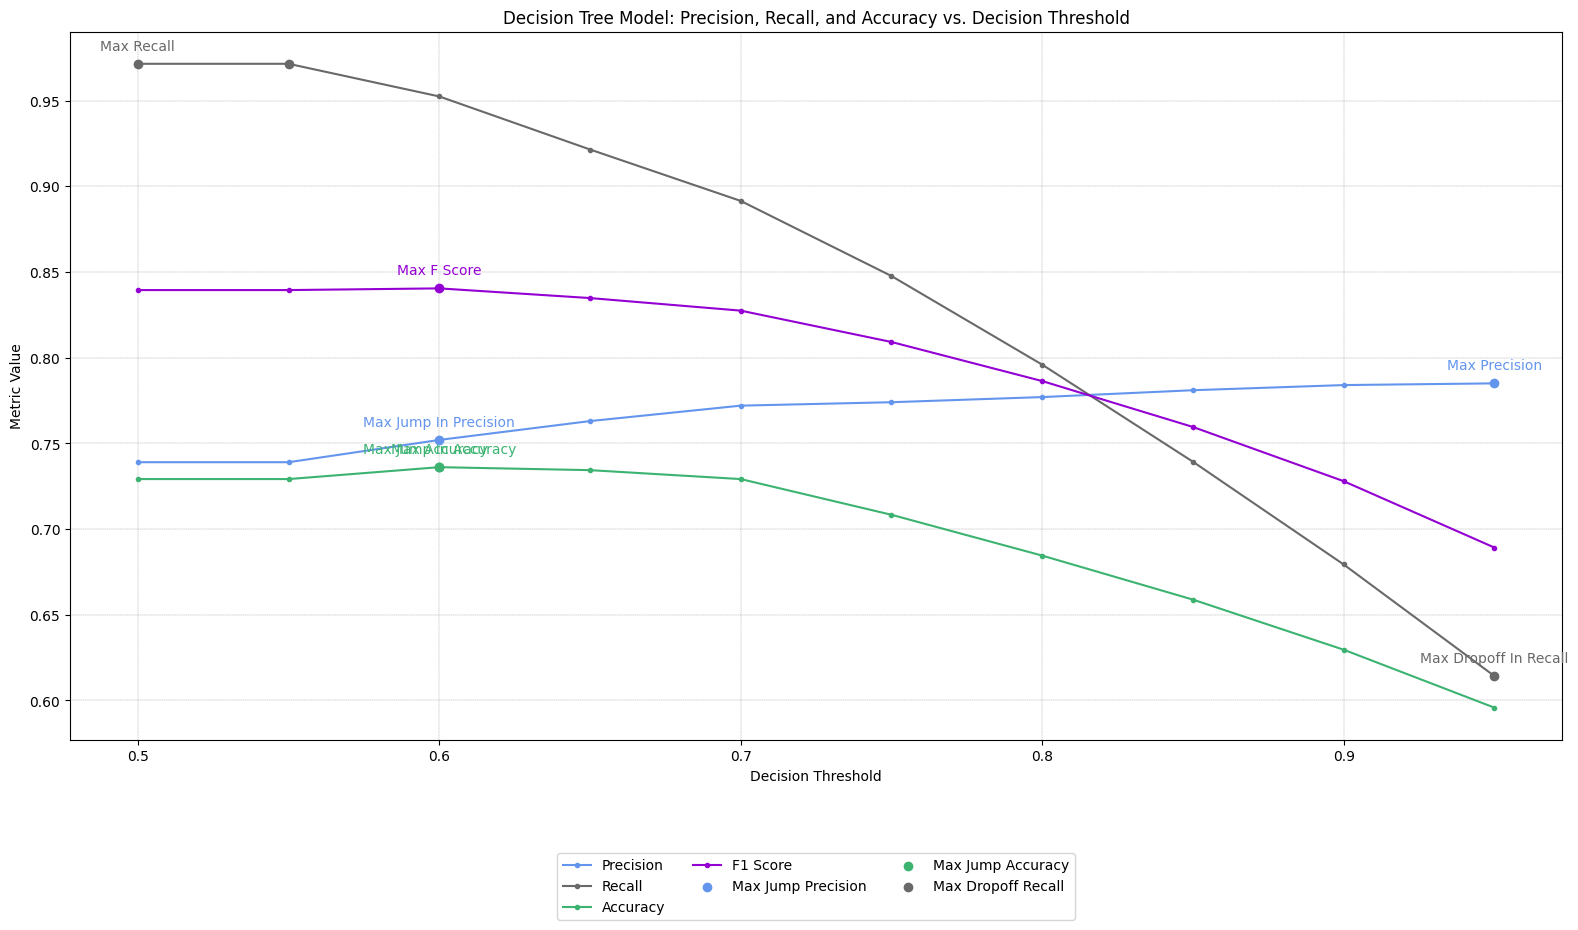

In [14]:
#Create Pipeline to be used in Gradient Boosting Classfier Model
Base_GBC_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('GBC_Model',GradientBoostingClassifier(random_state=state))])

#Fit the training data 
Base_GBC_Model_Pipeline.fit(X_train, y_train)

# Perform cross-validation
GBC_predictions = Base_GBC_Model_Pipeline.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, GBC_predictions)
print(f"\nTest Accuracy: {accuracy}\n")

# Generate  and Print a classification report
report = classification_report(y_val, GBC_predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)

#Get Predictions Probability 
predictions_array = Base_GBC_Model_Pipeline.predict_proba(X_val)[:, 1]

#Get y_values
true_arrray= y_val

#Create custom classification metrics 
metrics= CCM(true_arrray, predictions_array)

##Visualized  Metrics 
model_name= 'Decision Tree Model'
viz = TV(metrics,model_name)

### XGBoost Classifier


Test Accuracy: 0.6875

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.25      0.08      0.12        13
  Win Trades       0.73      0.91      0.81        35

    accuracy                           0.69        48
   macro avg       0.49      0.50      0.46        48
weighted avg       0.60      0.69      0.62        48



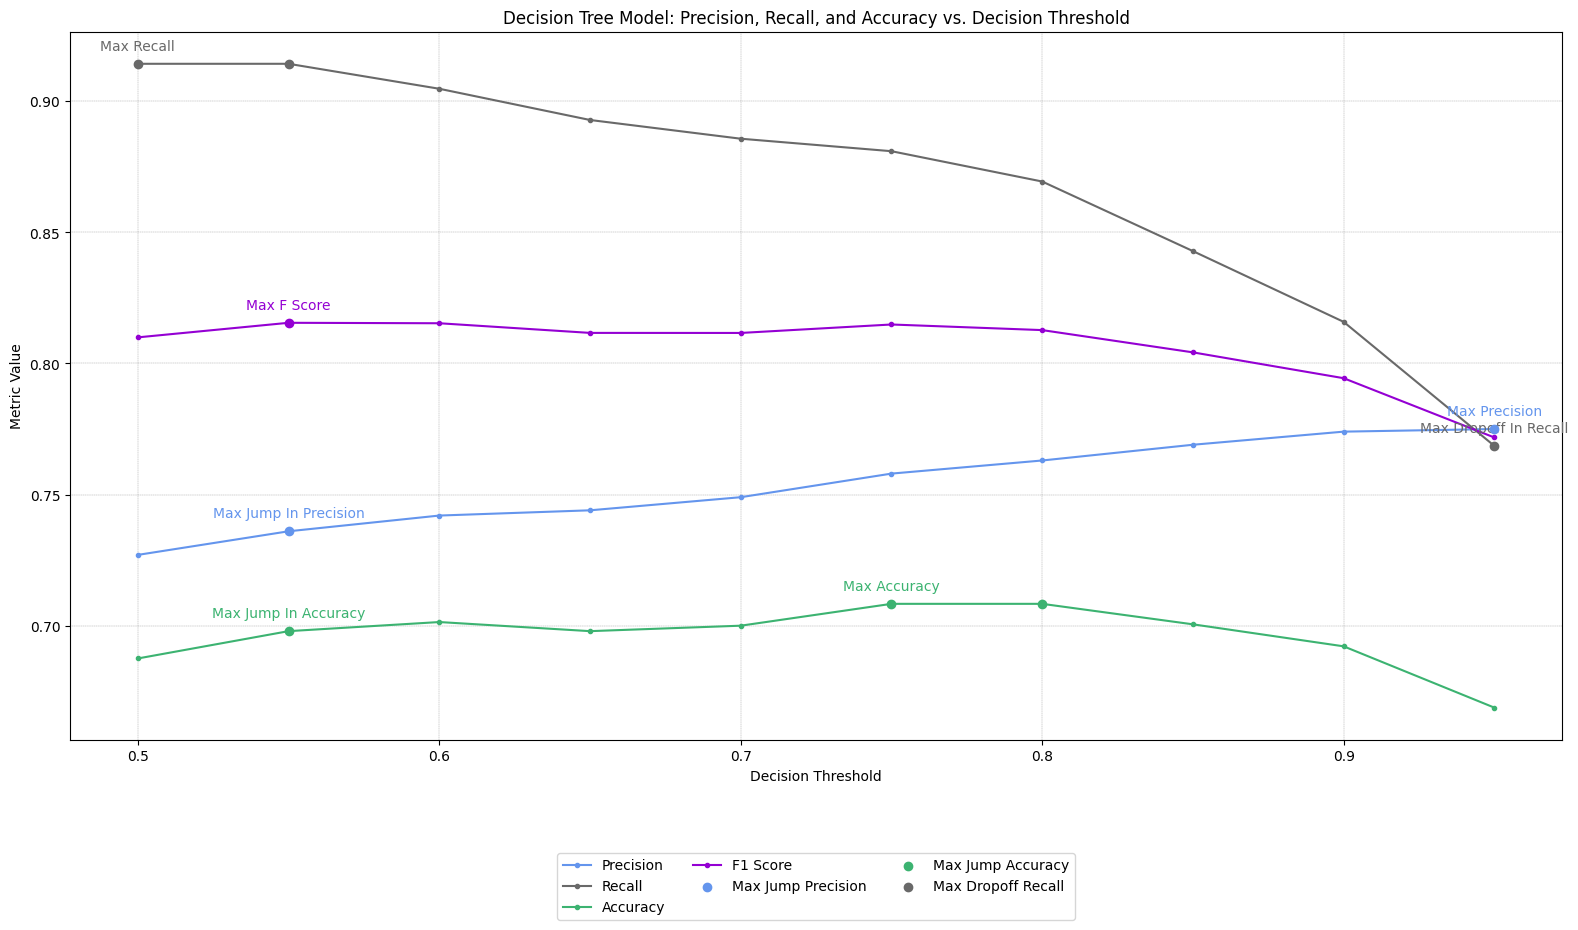

In [15]:
#Create Pipeline to be used in Gradient Boosting Classfier Model
Base_XGB_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('XGB_Model',xgb.XGBClassifier(random_state=state))])

#Fit the training data 
Base_XGB_Model_Pipeline.fit(X_train, y_train)

# Perform cross-validation
XGB_predictions = Base_XGB_Model_Pipeline.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, XGB_predictions)
print(f"\nTest Accuracy: {accuracy}\n")

# Generate  and Print a classification report
report = classification_report(y_val, XGB_predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)

#Get Predictions Probability 
predictions_array = Base_XGB_Model_Pipeline.predict_proba(X_val)[:, 1]

#Get y_values
true_arrray= y_val

#Create custom classification metrics 
metrics= CCM(true_arrray, predictions_array)

##Visualized  Metrics 
model_name= 'Decision Tree Model'
viz = TV(metrics,model_name)

# Grid Search & Cross Validate Top Models 

## Random Forest

In [29]:
def boosted_precision(y_true, y_pred_proba):
    y_pred_binary = (y_pred_proba >= .60).astype(int)
    precision = precision_score(y_true, y_pred_binary)
    return precision

# Define parameter grid for RandomForestClassifier
param_grid = {
    'RF_Model__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'RF_Model__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'RF_Model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'RF_Model__min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'RF_Model__max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

boosted_precision_scorer = make_scorer(boosted_precision, response_method='predict', greater_is_better=True)

grid_search_P = GridSearchCV(Base_RF_Model_Pipeline,param_grid=param_grid, cv=3,scoring='average_precision')
grid_search_P.fit(X_train, y_train)

# Get best parameters and score
best_params = grid_search_P.best_params_
best_score = grid_search_P.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Boosted Precision Score: {best_score}")

Best Parameters: {'RF_Model__max_depth': 10, 'RF_Model__max_features': 'log2', 'RF_Model__min_samples_leaf': 1, 'RF_Model__min_samples_split': 2, 'RF_Model__n_estimators': 200}
Best Boosted Precision Score: 0.6675044570964705


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Create Model Pipeline 
Base_SVC_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor), 
    ('SVC_Model', SVC())
])

# Fit the model using cross-validation
cv_scores = cross_val_score(Base_SVC_Model_Pipeline, X_train, y_train, cv=5) 

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Fit the model on the entire training data
Base_SVC_Model_Pipeline.fit(X_train, y_train)

# Make predictions on the test set
Base_SVC_Model_Predictions = Base_SVC_Model_Pipeline.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, Base_SVC_Model_Predictions)
print(f"\nTest Accuracy: {accuracy}\n")

# Generate a classification report
report = classification_report(y_val, Base_SVC_Model_Predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)

#Get Predictions Probability 
predictions_array = Base_SVC_Model_Pipeline.predict_proba(X_val)[:, 1]

#Get y_values
true_arrray= y_val

#Create custom classification metrics 
metrics= CCM(true_arrray, predictions_array)

##Visualized  Metrics 
model_name= 'Decision Tree Model'
viz = TV(metrics,model_name)

Cross-validation scores: [0.67948718 0.68831169 0.68831169 0.67532468 0.67532468]
Mean CV accuracy: 0.6813519813519813

Test Accuracy: 0.7291666666666666

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.00      0.00      0.00        13
  Win Trades       0.73      1.00      0.84        35

    accuracy                           0.73        48
   macro avg       0.36      0.50      0.42        48
weighted avg       0.53      0.73      0.61        48



AttributeError: This 'Pipeline' has no attribute 'predict_proba'

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Create Model Pipeline 
Base_SVC_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor), 
    ('GBC_Model',GradientBoostingClassifier())
])

# Fit the model using cross-validation
cv_scores = cross_val_score(Base_SVC_Model_Pipeline, X_train, y_train, cv=5) 

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Fit the model on the entire training data
Base_SVC_Model_Pipeline.fit(X_train, y_train)

# Make predictions on the test set
Base_SVC_Model_Predictions = Base_SVC_Model_Pipeline.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, Base_SVC_Model_Predictions)
print(f"\nTest Accuracy: {accuracy}\n")

# Generate a classification report
report = classification_report(y_test, Base_SVC_Model_Predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)


Cross-validation scores: [0.57692308 0.61038961 0.61038961 0.58441558 0.68831169]
Mean CV accuracy: 0.6140859140859141

Test Accuracy: 0.7755102040816326

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.00      0.00      0.00         8
  Win Trades       0.83      0.93      0.87        41

    accuracy                           0.78        49
   macro avg       0.41      0.46      0.44        49
weighted avg       0.69      0.78      0.73        49



In [25]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Create Model Pipeline 
Base_SVC_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor), 
    ('RF_Model', RandomForestClassifier(random_state=42))
])

# Fit the model using cross-validation
cv_scores = cross_val_score(Base_SVC_Model_Pipeline, X_train, y_train, cv=5) 

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Fit the model on the entire training data
Base_SVC_Model_Pipeline.fit(X_train, y_train)

# Make predictions on the test set
Base_SVC_Model_Predictions = Base_SVC_Model_Pipeline.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, Base_SVC_Model_Predictions)
print(f"\nTest Accuracy: {accuracy}\n")

# Generate a classification report
report = classification_report(y_test, Base_SVC_Model_Predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)


Cross-validation scores: [0.48717949 0.67532468 0.62337662 0.50649351 0.5974026 ]
Mean CV accuracy: 0.577955377955378

Test Accuracy: 0.8367346938775511

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.00      0.00      0.00         8
  Win Trades       0.84      1.00      0.91        41

    accuracy                           0.84        49
   macro avg       0.42      0.50      0.46        49
weighted avg       0.70      0.84      0.76        49



In [26]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Create Model Pipeline 
Base_SVC_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor), 
    ('XGB_Model',xgb.XGBClassifier())
])

# Fit the model using cross-validation
cv_scores = cross_val_score(Base_SVC_Model_Pipeline, X_train, y_train, cv=5) 

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Fit the model on the entire training data
Base_SVC_Model_Pipeline.fit(X_train, y_train)

# Make predictions on the test set
Base_SVC_Model_Predictions = Base_SVC_Model_Pipeline.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, Base_SVC_Model_Predictions)
print(f"\nTest Accuracy: {accuracy}\n")

# Generate a classification report
report = classification_report(y_test, Base_SVC_Model_Predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)


Cross-validation scores: [0.6025641  0.61038961 0.61038961 0.50649351 0.51948052]
Mean CV accuracy: 0.5698634698634699

Test Accuracy: 0.8367346938775511

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.50      0.25      0.33         8
  Win Trades       0.87      0.95      0.91        41

    accuracy                           0.84        49
   macro avg       0.68      0.60      0.62        49
weighted avg       0.81      0.84      0.81        49



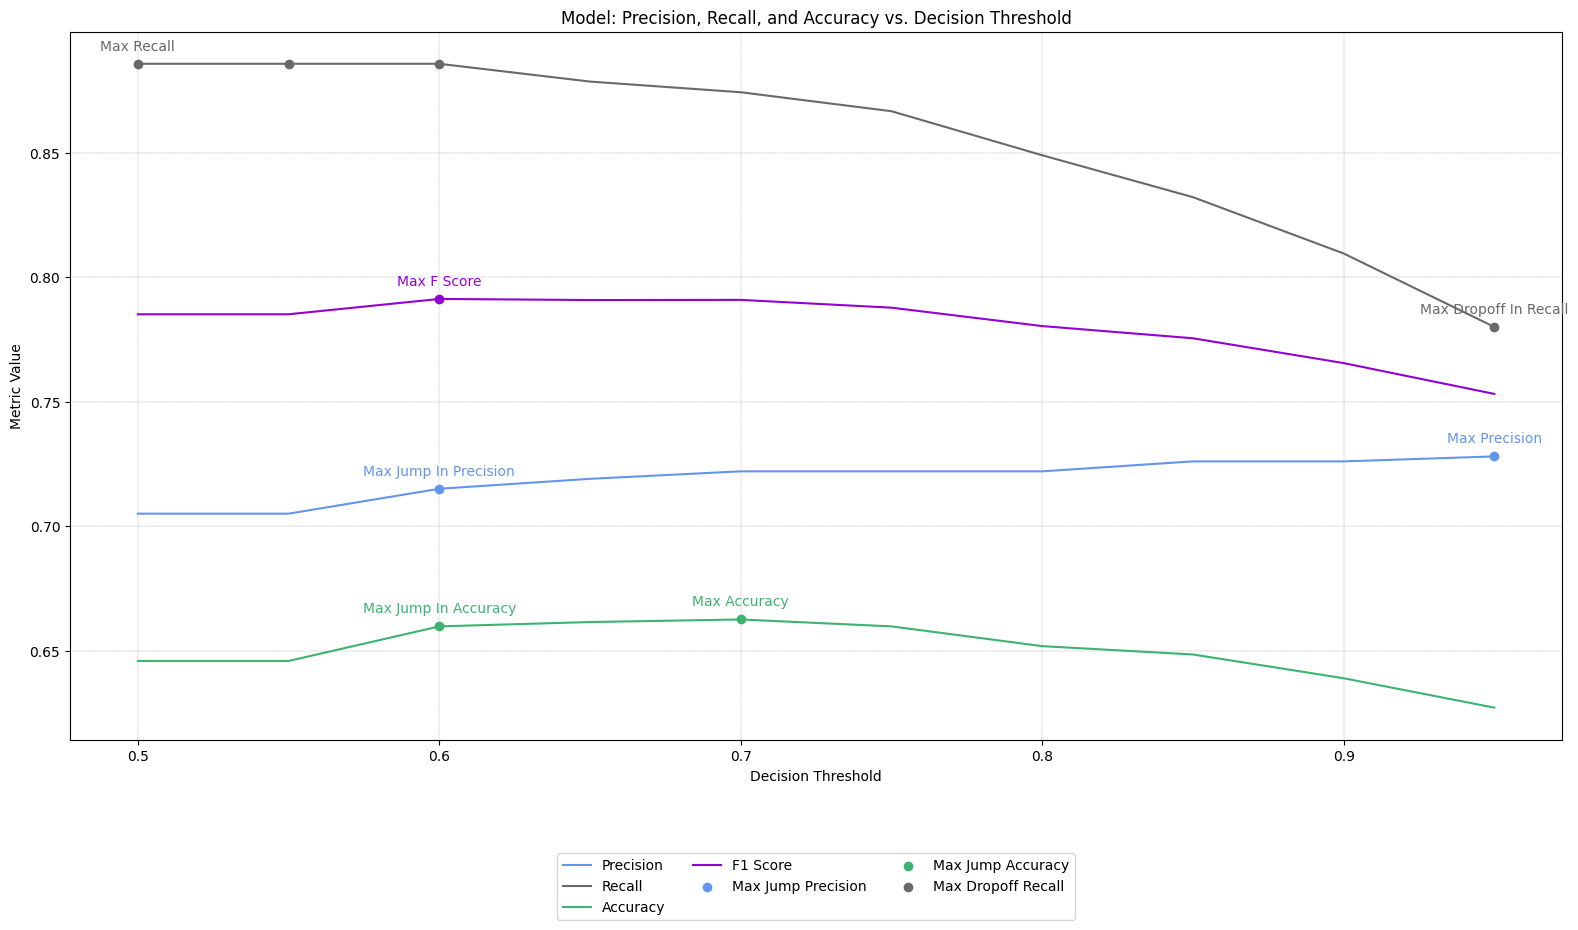

In [146]:
predictions_array = Base_SVC_Model_Pipeline.predict_proba(X_test)[:, 1]
true_arrray= y_val
metrics= custom_classification_metrics(true_arrray, predictions_array)
viz = threshold_viz(metrics)


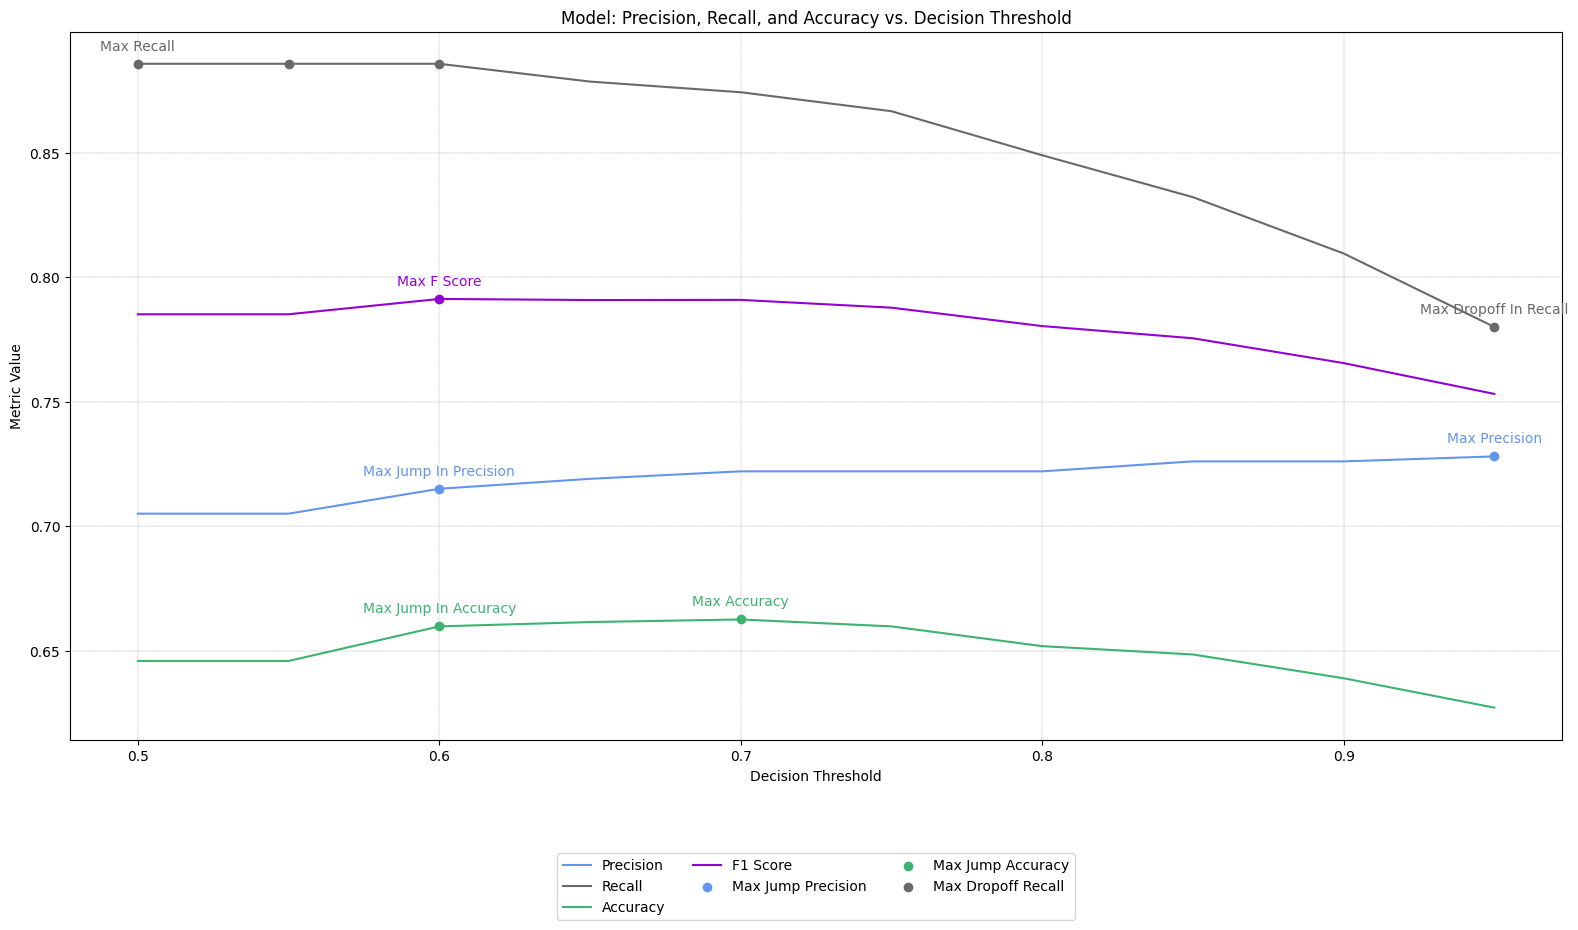

In [40]:
recall_list

[0.886, 0.886, 0.886, 0.879, 0.874, 0.867, 0.849, 0.832, 0.81, 0.78]

In [73]:
f1_list

[0.7852042740414834,
 0.7852042740414834,
 0.791367895065584,
 0.7909899874843555,
 0.7907619047619047,
 0.787884203901825,
 0.7803666454487587,
 0.7753940949935815,
 0.765703125,
 0.7531034482758621]

## Grid Search

### Random Forest Model

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid to use for the grid search
# param_grid = {
#     'RF_Model__n_estimators': [25,50, 100, 200],  
#     'RF_Model__criterion': ['gini', 'entropy'],  
#     'RF_Model__max_depth': [None, 10, 20, 30],  
#     'RF_Model__min_samples_split': [2, 5, 10],  
#     'RF_Model__min_samples_leaf': [1, 2, 4], 
#     'RF_Model__max_features': ['sqrt', 'log2', None],  
#     'RF_Model__bootstrap': [True,],  
#     'RF_Model__ccp_alpha': [0.0, 0.01, 0.1], 
#     'RF_Model__max_samples': [None, 0.5, 0.75]  
# }
# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=Base_RF_Model_Pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and the best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score found: ", grid_search.best_score_)


### Grid Search Metrics For Random Forest Model

In [ ]:
# # Create Model Pipeline
# Base_RF_Model_Pipeline = Pipeline(steps=[
#     ('Preprocessor', Preprocessor),
#     ('Feature_Selection', Selection),
#     ('RF_Model', RandomForestClassifier(random_state=42,
                                       
#                                        ccp_alpha=  0.0,
#                                        criterion ='entropy',
#                                        max_depth= 20,
#                                        max_features= 'sqrt',
#                                        min_samples_leaf= 2,
#                                        min_samples_split= 2,
#                                        n_estimators= 100,
#                                        bootstrap= False,
#                                        max_samples= None,
# ))  
# ])

# # Perform cross-validation
# RF_CV_accuracy = cross_val_score(Base_RF_Model_Pipeline, X, Y, cv=10, scoring='accuracy').mean()
# RF_CV_predictions = cross_val_predict(Base_RF_Model_Pipeline, X, Y, cv=10)

# # Calculate recall, precision, and F1 score for each fold
# RF_CV_recall = recall_score(Y, RF_CV_predictions, average=None).mean()
# RF_CV_precision = precision_score(Y, RF_CV_predictions, average=None).mean()
# RF_CV_f1_score = f1_score(Y, RF_CV_predictions, average=None).mean()

# # Display the metrics
# print("Accuracy:", RF_CV_accuracy)
# print("Recall:", RF_CV_recall)
# print("Precision:", RF_CV_precision)
# print("F1 Score:", RF_CV_f1_score)

In [ ]:
# ??RandomForestClassifier

In [ ]:
# # Define the parameter grid, prefixing each parameter with the name of the pipeline step followed by two underscores
# param_grid = {
#     'GBC_Model__loss': ['deviance', 'exponential'],
#     'GBC_Model__learning_rate': [0.01, 0.1, 0.5],
#     'GBC_Model__n_estimators': [50, 100, 200],
#     'GBC_Model__subsample': [0.5, 0.75, 1.0],
#     'GBC_Model__criterion': ['friedman_mse', 'mse', 'mae'],
#     'GBC_Model__min_samples_split': [2, 5, 10],
#     'GBC_Model__min_samples_leaf': [1, 2, 4],
#     'GBC_Model__max_depth': [3, 5, 10],
#     'GBC_Model__min_impurity_decrease': [0.0, 0.1, 0.2],
#     'GBC_Model__max_features': ['auto', 'sqrt', 'log2', None],
#     'GBC_Model__warm_start': [True, False]
# }

# # Create GridSearchCV
# grid_search = GridSearchCV(estimator=Base_GBC_Model_Pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_

# print("Best parameters found:")
# print(best_params)

In [ ]:
# ??RandomForestClassifier

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid to use for the grid search
# param_grid = {
#     'RF_Model__n_estimators': [10, 20,30,50,75, 100,150, 200],  # Number of trees in the forest
#     'RF_Model__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
#     'RF_Model__max_depth': [None,5, 10,15, 20],  # Maximum depth of the tree
#     'RF_Model__min_samples_split': [2, 5, 10, 15,],  # Minimum number of samples required to split an internal node
#     'RF_Model__min_samples_leaf': [1,3, 5],  # Minimum number of samples required to be at a leaf node
#     'RF_Model__max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
#     # Note: For max_features, None means that max_features=n_features
#     'RF_Model__bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
#     'RF_Model__ccp_alpha': [0.0, 0.01, 0.1],  # Complexity parameter used for Minimal Cost-Complexity Pruning
#     'RF_Model__max_samples': [None,0.25, 0.5, 0.75]  # If bootstrap is True, the number of samples to draw from X to train each base estimator
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=Base_RF_Model_Pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# # Assuming X_train and y_train are already defined
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and the best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score found: ", grid_search.best_score_)


In [ ]:
# #Create Pipeline to be used in Gradient Boosting Classfier Model
# Base_GBC_Model_Pipeline = Pipeline(steps=[
#     ('Preprocessor', Preprocessor),
#     ('GBC_Model',GradientBoostingClassifier())])

# # Perform cross-validation
# GBC_CV_accuracy = cross_val_score(Base_GBC_Model_Pipeline, X, Y, cv=5, scoring='accuracy').mean()
# GBC_CV_predictions = cross_val_predict(Base_GBC_Model_Pipeline, X, Y, cv=5)

# # Calculate recall, precision, and F1 score for each fold
# GBC_CV_recall = recall_score(Y, GBC_CV_predictions, average=None).mean()
# GBC_CV_precision = precision_score(Y, GBC_CV_predictions, average=None).mean()
# GBC_CV_f1_score = f1_score(Y, GBC_CV_predictions, average=None).mean()

# # Display the metrics
# print("Accuracy:", GBC_CV_accuracy)
# print("Recall:", GBC_CV_recall)
# print("Precision:", GBC_CV_precision)
# print("F1 Score:", GBC_CV_f1_score)


In [ ]:
# #Create Pipeline to be used in Gradient Boosting Classfier Model
# Base_GBC_Model_Pipeline = Pipeline(steps=[
#     ('Preprocessor', Preprocessor),
#     ('GBC_Model',GradientBoostingClassifier(
#     learning_rate=0.1,
#     n_estimators=100,
#     subsample=.75,
#     criterion='friedman_mse',
#     min_samples_split=10,
#     min_samples_leaf=4,
#     max_depth=5,
#     min_impurity_decrease=0.1,
#     random_state=42,
#     max_features='sqrt',
#     verbose=0,
#     max_leaf_nodes=None,
#     warm_start=False,
#     validation_fraction=0.1,
#    ))])

# # Perform cross-validation
# GBC_CV_accuracy = cross_val_score(Base_GBC_Model_Pipeline, X, Y, cv=5, scoring='accuracy').mean()
# GBC_CV_predictions = cross_val_predict(Base_GBC_Model_Pipeline, X, Y, cv=5)

# # Calculate recall, precision, and F1 score for each fold
# GBC_CV_recall = recall_score(Y, GBC_CV_predictions, average=None).mean()
# GBC_CV_precision = precision_score(Y, GBC_CV_predictions, average=None).mean()
# GBC_CV_f1_score = f1_score(Y, GBC_CV_predictions, average=None).mean()

# # Display the metrics
# print("Accuracy:", GBC_CV_accuracy)
# print("Recall:", GBC_CV_recall)
# print("Precision:", GBC_CV_precision)
# print("F1 Score:", GBC_CV_f1_score)

In [ ]:
# from sklearn.model_selection import cross_validate, StratifiedKFold

# # Define StratifiedKFold
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Define scoring metrics
# scoring = ['accuracy', 'recall', 'precision', 'f1']

# # Perform cross-validation
# cv_results = cross_validate(Base_GBC_Model_Pipeline, X, Y, cv=skf, scoring=scoring)

# # Calculate the mean of each metric
# accuracy_mean = cv_results['test_accuracy'].mean()
# recall_mean = cv_results['test_recall'].mean()
# precision_mean = cv_results['test_precision'].mean()
# f1_mean = cv_results['test_f1'].mean()

# print("StratifiedKFold CV Results:")
# print(f"Accuracy: {accuracy_mean}")
# print(f"Recall: {recall_mean}")
# print(f"Precision: {precision_mean}")
# print(f"F1 Score: {f1_mean}")


# Tuned Models 

In [ ]:
# #Create Pipeline to be used in Gradient Boosting Classfier Model
# Base_GBC_Model_Pipeline = Pipeline(steps=[
#     ('Preprocessor', Preprocessor),
#     ('GBC_Model',GradientBoostingClassifier(
#     learning_rate=0.1,
#     n_estimators=100,
#     subsample=.75,
#     criterion='friedman_mse',
#     min_samples_split=10,
#     min_samples_leaf=4,
#     max_depth=5,
#     min_impurity_decrease=0.1,
#     random_state=42,
#     max_features='sqrt',
#     verbose=0,
#     max_leaf_nodes=None,
#     warm_start=False,
#     validation_fraction=0.1,
#    ))])

# #Fit the training data 
# Base_GBC_Model_Pipeline.fit(X_train, y_train)

# # Perform cross-validation
# GBC_predictions = Base_GBC_Model_Pipeline.predict(X_test)

# # Calculate the accuracy of the model
# accuracy = accuracy_score(y_test, GBC_predictions)
# print(f"\nTest Accuracy: {accuracy}\n")

# # Generate  and Print a classification report
# report = classification_report(y_test, GBC_predictions, target_names=["Loss Trades", "Win Trades"]) 
# print("Classification Report:\n", report)

In [ ]:
from sklearn.model_selection import ShuffleSplit

# Define ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform cross-validation
cv_results = cross_validate(Base_GBC_Model_Pipeline, X, Y, cv=ss, scoring=scoring)

# Calculate the mean of each metric
accuracy_mean = cv_results['test_accuracy'].mean()
recall_mean = cv_results['test_recall'].mean()
precision_mean = cv_results['test_precision'].mean()
f1_mean = cv_results['test_f1'].mean()

print("ShuffleSplit CV Results:")
print(f"Accuracy: {accuracy_mean}")
print(f"Recall: {recall_mean}")
print(f"Precision: {precision_mean}")
print(f"F1 Score: {f1_mean}")


In [ ]:
import numpy as np

In [ ]:
# grid = GridSearchCV(Base_GBC_Model_Pipeline, params, cv=5, scoring='accuracy')
# grid.fit(X,Y)

### There might be an issue between the Recall and Precision value of Logistic Regression - do not delete this until investigate further 

### Feature Importance

In [ ]:
#Retrived the Feature Selection Step 
feature_selection = Base_RF_Model_Pipeline.named_steps['Feature_Selection']

#Retrieve the trained model 
trained_RF_Model = Base_RF_Model_Pipeline.named_steps['RF_Model']

feature_importances = trained_RF_Model.feature_importances_

# Get the indices of selected features
selected_feature_indices = feature_selection.get_support(indices=True)

# Extract feature names
all_feature_names = Preprocessor.get_feature_names_out()
selected_feature_names = [all_feature_names[i] for i in selected_feature_indices]

# Combine feature names with their importances
features_and_importances = zip(selected_feature_names, feature_importances)

# Sort features by importance
sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)


# Create a DataFrame from the features and importances
feature_importance_df = pd.DataFrame(sorted_features_and_importances, columns=['Feature', 'Importance'])

# Display the DataFrame
feature_importance_df.head(20)

## Reference: Concepts To Understand 

#### Accuracy: 
                - Measures the overall correctness of the classifier. It's calculated by dividing the number of correctly classifier samples by the total number of samples. 
                - Accuracy tells us how often the classifier correctly predicted whether a trade is a successful or not compared to the total number of trades.
                - An Accuracy of .76 means that classifier correctly predicted the trade status for approximately 76% of the time. 
                
#### Recall:
             - Also known as sensitivity or true positive, measures  the ability of the classifier to correctly identify all positive instances. 
             - In the context of a trade status classifier, recall tells us how often the classifier correctly identified out of all successful trades.
             - A recall of approximately .795 means that the classifier correctly identified 79.5% of the successful trades. 
#### Precision 
              - Measures the ability of the classifier to correctly identify only relevant instances among all instances it has classified as positive. 
              - In the context of a trade status classifier, precision measures the proportion of correctly predicted successful trades out of all successful trades.
              - A precision of approximately .933 means that about 93.3% of the trades predicted as successful by the classifier were actually successful. 
#### F1 Score
                - Is a metric that combines precision and recall into a single value - it is the harmonic mean between precision and recall. 
                - Precision measures the proportion of correctly predicted positive cases among all predicted cases.
                - While Recall, measures the proportion of correctly predicted positive cases among all actual positive cases.
                - F1 Score provides a balance between precision and recall, it is especially useful when there is an uneven class distribution.
                - In the context of a trade status classifier, an F1 Score of .859 indicate a good balance between precision and recall predicting whether trades were successful or not. 


### Example Summary and Key Takeaways

#### Performance Overview
- **Test Accuracy**: 75%.

#### Insights from Classification Report
- **'Win Trades' (Positive Class)**:
  - Precision: ~76%
  - Recall: ~97%
  - F1-score: ~0.85
- **'Loss Trades' (Negative Class)**:
  - Precision: ~67%
  - Recall: ~15%
  - F1-score: ~0.25

#### Key Takeaways
1. **Strong Performance on Majority Class**:
   - The model is highly effective in predicting 'Win Trades', with high precision and recall. This indicates strong performance for the majority class.
2. **Challenges with Minority Class**:
   - Despite a reasonable precision, the recall for 'Loss Trades' is very low, suggesting that the model struggles to identify this class correctly. The low recall for 'Loss Trades' needs addressing to balance the model's performance across classes.
3. **Potential for Model Tuning**:
   - Improving the model's ability to detect 'Loss Trades' could involve tuning hyperparameters, exploring different model architectures, or employing techniques aimed at balancing class representation.
4. **Metrics Indicating Room for Improvement**:
   - While the overall accuracy is good, the macro averages for precision, recall, and F1-score suggest that the performance across classes is uneven, reinforcing the need for model refinement to ensure fairness and robustness.

This summary pinpoints where the model excels and where improvements are necessary, especially in handling the minority class more effectively.
